This week's post is about `mlsauce` (again), and `LSBoost` in particular. No new [working paper](https://www.researchgate.net/publication/346059361_LSBoost_gradient_boosted_penalized_nonlinear_least_squares) (still working on it), but:

- A new updated [documentation page](https://techtonique.r-universe.dev/mlsauce)

- An updated [R version](https://techtonique.r-universe.dev/builds), working at least on Linux and macOS (Windows users, if not working on your machine, give a try to the _Windows Subsystem for Linux_, WSL)

# 0 - import packages

Importing `mlsauce` from GitHub remains the preferred way to install it.

In [1]:
#!pip install numpy matplotlib scikit-learn

In [ ]:
!pip install git+https://github.com/Techtonique/mlsauce.git --verbose

In [3]:
# Importing necessary libraries
import mlsauce as ms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA # Non-linear dimensionality reduction through the use of kernels
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1 - Data preprocessing

In [4]:
# Load breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
print(X.shape)
print(y.shape)


(569, 30)
(569,)


## 1 - 1 Kernel PCA features

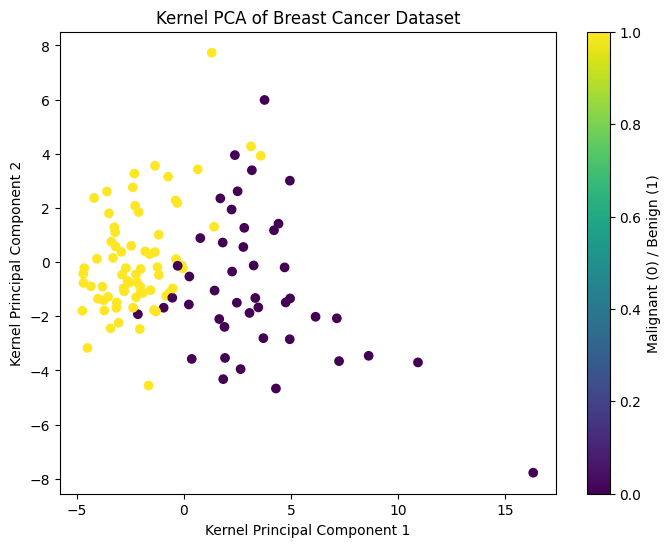

In [5]:

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform Kernel PCA to extract 2 'good' features
# (easier to visualize)
kpca = KernelPCA(n_components=2)
X_kpca = kpca.fit_transform(X_scaled)
# Splitting the dataset into training and testing sets
X_train_kpca, X_test_kpca, y_train, y_test = train_test_split(X_kpca, y, test_size=0.2,
                                                    random_state=32)

# Plotting the two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_test_kpca[:, 0], X_test_kpca[:, 1], c=y_test, cmap='viridis')
plt.xlabel('Kernel Principal Component 1')
plt.ylabel('Kernel Principal Component 2')
plt.title('Kernel PCA of Breast Cancer Dataset')
plt.colorbar(label='Malignant (0) / Benign (1)')
plt.show()

## 1 - 2 'Important' features

[0.03484323 0.01522515 0.06799034 0.06046164 0.00795845 0.01159704
 0.06691736 0.10704566 0.00342279 0.00261508 0.0142637  0.00374427
 0.01008506 0.02955283 0.00472157 0.00561183 0.00581969 0.00375975
 0.00354597 0.00594233 0.08284828 0.01748526 0.0808497  0.13935694
 0.01223202 0.01986386 0.03733871 0.13222509 0.00817908 0.00449731]
[23 27  7 20 22  2  6  3 26  0 13 25 21  1 10 24  5 12 28  4 19 16 15 14
 29 17 11 18  8  9]
['worst area' 'worst concave points']


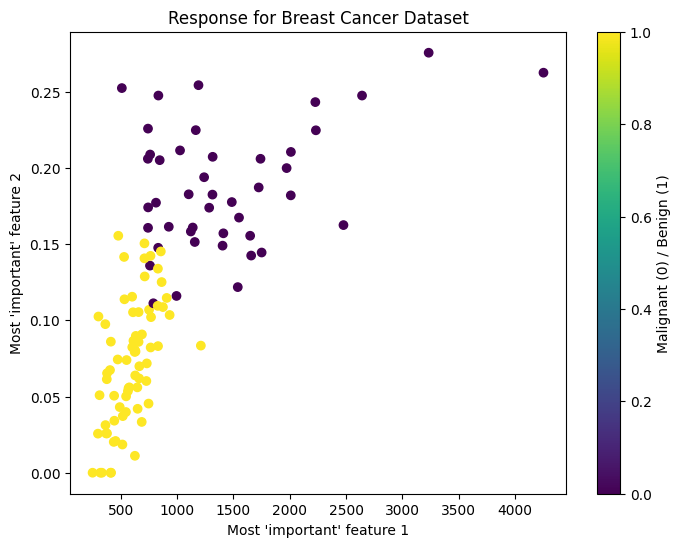

In [6]:
# Training a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)

# Feature importances
importances = rf_classifier.feature_importances_
print(importances)
indices = np.argsort(importances)[::-1]
print(indices)

# Select top 2 features
top_two_indices = indices[:2]
print(data.feature_names[top_two_indices])
X_rf = X[:,top_two_indices]

# Splitting the dataset into training and testing sets
X_train_rf, X_test_rf, y_train, y_test = train_test_split(X_rf, y, test_size=0.2,
                                                    random_state=32)


# Plotting the two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_test_rf[:, 0], X_test_rf[:, 1], c=y_test, cmap='viridis')
plt.xlabel("Most 'important' feature 1")
plt.ylabel("Most 'important' feature 2")
plt.title('Response for Breast Cancer Dataset')
plt.colorbar(label='Malignant (0) / Benign (1)')
plt.show()


# 2 - Adjust LSBoostClassifier

In [ ]:
!pip install GPopt

In [8]:
import GPopt as gp
import mlsauce as ms
from sklearn.model_selection import cross_val_score


opt_objects_lsboost = []

def lsboost_cv(X_train, y_train,
               n_estimators=100,
               learning_rate=0.1,
               n_hidden_features=5,
               reg_lambda=0.1,
               dropout=0,
               tolerance=1e-4,
               n_clusters=2,
               seed=123,
               solver="ridge"):

  estimator = ms.LSBoostClassifier(n_estimators=int(n_estimators),
                                   learning_rate=learning_rate,
                                   n_hidden_features=int(n_hidden_features),
                                   reg_lambda=reg_lambda,
                                   dropout=dropout,
                                   tolerance=tolerance,
                                   n_clusters=int(n_clusters),
                                   seed=seed, solver=solver, verbose=0)

  return -cross_val_score(estimator, X_train, y_train,
                          scoring='f1_macro', cv=5).mean()

def optimize_lsboost(X_train, y_train, solver="ridge"):

  # objective function for hyperparams tuning
  def crossval_objective(x):

    return lsboost_cv(
      X_train=X_train,
      y_train=y_train,
      n_estimators=int(x[0]),
      learning_rate=x[1],
      n_hidden_features=int(x[2]),
      reg_lambda=x[3],
      dropout=x[4],
      tolerance=x[5],
      n_clusters=int(x[6]),
      solver = solver)

  gp_opt = gp.GPOpt(objective_func=crossval_objective,
                      lower_bound = np.array([ 10, 0.001,   5, 1e-2,   0,    0, 0]),
                      upper_bound = np.array([250,   0.4, 250,  1e4, 0.7, 1e-1, 4]),
                      params_names=["n_estimators", "learning_rate",
                                    "n_hidden_features", "reg_lambda",
                                    "dropout", "tolerance", "n_clusters"],
                      n_init=10, n_iter=190, seed=123)
  return {'parameters': gp_opt.optimize(verbose=2, abs_tol=1e-2), 'opt_object':  gp_opt}

In [ ]:
opt_objects_lsboost.append(optimize_lsboost(X_train_kpca, y_train, solver="ridge"))
opt_objects_lsboost.append(optimize_lsboost(X_train_rf, y_train, solver="ridge"))

# 3 - Graphs

In [10]:
display(opt_objects_lsboost[0]['parameters'].best_params)
display(opt_objects_lsboost[1]['parameters'].best_params)

opt_objects_lsboost[0]['parameters'].best_params['n_estimators'] = int(opt_objects_lsboost[0]['parameters'].best_params['n_estimators'])
opt_objects_lsboost[1]['parameters'].best_params['n_estimators'] = int(opt_objects_lsboost[1]['parameters'].best_params['n_estimators'])
opt_objects_lsboost[0]['parameters'].best_params['n_hidden_features'] = int(opt_objects_lsboost[0]['parameters'].best_params['n_hidden_features'])
opt_objects_lsboost[1]['parameters'].best_params['n_hidden_features'] = int(opt_objects_lsboost[1]['parameters'].best_params['n_hidden_features'])
opt_objects_lsboost[0]['parameters'].best_params['n_clusters'] = int(opt_objects_lsboost[0]['parameters'].best_params['n_clusters'])
opt_objects_lsboost[1]['parameters'].best_params['n_clusters'] = int(opt_objects_lsboost[1]['parameters'].best_params['n_clusters'])

{'n_estimators': 221.10595703125,
 'learning_rate': 0.12772097778320313,
 'n_hidden_features': 45.053253173828125,
 'reg_lambda': 2496.6505697631837,
 'dropout': 0.2851226806640625,
 'tolerance': 0.0047698974609375,
 'n_clusters': 3.1986083984375}

{'n_estimators': 193.544921875,
 'learning_rate': 0.3466668701171875,
 'n_hidden_features': 208.9971923828125,
 'reg_lambda': 1866.4632116699217,
 'dropout': 0.37947998046875,
 'tolerance': 0.01290283203125,
 'n_clusters': 3.04443359375}

100%|██████████| 51/51 [00:00<00:00, 61.11it/s]


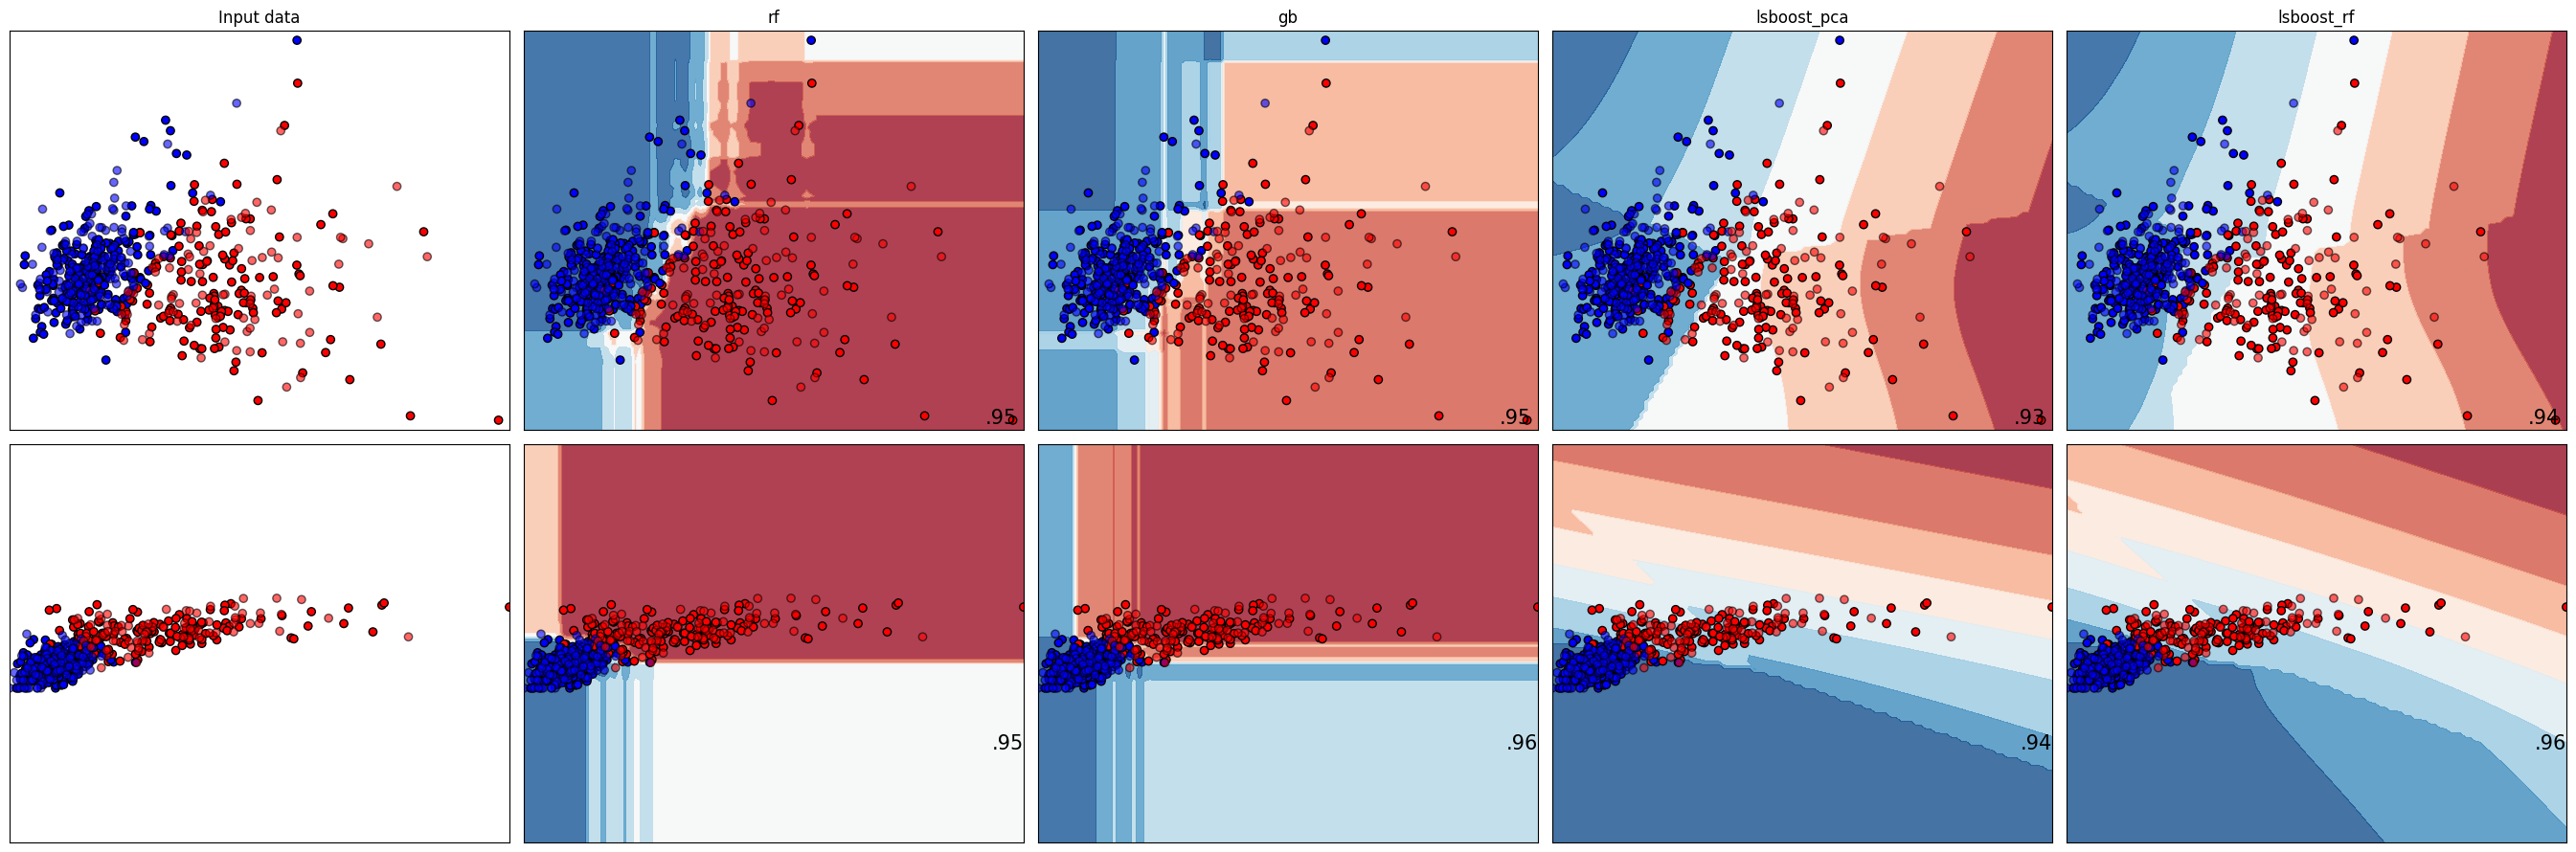

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier


classifiers = [RandomForestClassifier(),
               GradientBoostingClassifier(),
               ms.LSBoostClassifier(**opt_objects_lsboost[0]['parameters'].best_params),
               ms.LSBoostClassifier(**opt_objects_lsboost[1]['parameters'].best_params)]

names = ["rf", "gb", "lsboost_pca", "lsboost_rf"]


figure = plt.figure(figsize=(27, 9))
i = 1

datasets = [(X_kpca, y), (X_rf, y)]

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds[0], ds[1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        try:
            score = clf.score(X_test, y_test)
        except: # no scoring method available yet for prediction sets
            score = np.mean(clf.predict_proba(X_test).argmax(axis=1) == y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()